<a href="https://colab.research.google.com/github/peter-ohara/chicken_tinder/blob/master/chicken_tinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import warnings
from random import randrange
from shutil import copyfile

from PIL import Image
from google.colab import drive, files
from imutils import paths


def cleanup_images(img_source_dir):
    if not (isinstance(img_source_dir, str)):
        raise AttributeError('img_source_dir must be a string')

    if not os.path.exists(img_source_dir):
        raise OSError('img_source_dir does not exist')

    # loop over the image paths in img_source_dir
    for imagePath in paths.list_images(img_source_dir):
        try:
            with warnings.catch_warnings(record=True) as _w:

                # Cause all warnings to be treated as errors
                # warnings.simplefilter("error")

                # open and verify image file
                img = Image.open(imagePath)
                img.verify()

                # Open and convert image to jpg if it's not already jpg
                img = Image.open(imagePath)
                if img.format != 'JPEG':
                    print(f"Converting '{imagePath}' to .jpg")

                    # Convert image
                    img = img.convert('RGB')

                    # Save jpg file
                    imagePathSansExt = imagePath.split('.')[0]
                    img.save(f"{imagePathSansExt}.jpg")

                    # Delete original file
                    os.remove(imagePath)

        # If any of the above fails, the file is corrupt so delete it
        except (IOError, SyntaxError) as e:
            # Delete the image
            print(f"Deleting '{imagePath}'... {type(e).__name__}: {e}")
            os.remove(imagePath)


def img_train_test_split(img_source_dir, test_size, train_dir='train', test_dir='test'):
    """
    Randomly splits images over a train, and test folder, while preserving the folder structure

    Parameters
    ----------
    img_source_dir : string
        Path to the folder with the images to be split. Can be absolute or relative path

    test_size : float
        Proportion of the original images that need to be copied in the subdirectory in the test folder
    """
    if not (isinstance(img_source_dir, str)):
        raise AttributeError('img_source_dir must be a string')

    if not os.path.exists(img_source_dir):
        raise OSError('img_source_dir does not exist')

    if not (isinstance(test_size, float)):
        raise AttributeError('test_size must be a float')

    train_dir_path = f'data/{train_dir}'
    test_dir_path = f'data/{test_dir}'

    setup_empty_folder_structure(test_dir_path, train_dir_path)

    # Get the subdirectories in the main image folder
    subdirs = [subdir for subdir in os.listdir(img_source_dir) if os.path.isdir(os.path.join(img_source_dir, subdir))]

    copy_files_by_test_size(img_source_dir, subdirs, test_dir_path, test_size, train_dir_path)


def setup_empty_folder_structure(test_dir_path, train_dir_path):
    # Set up empty folder structure if not exists
    if not os.path.exists('data'):
        os.makedirs('data')
    else:
        if not os.path.exists(train_dir_path):
            os.makedirs(train_dir_path)
        if not os.path.exists(test_dir_path):
            os.makedirs(test_dir_path)


def copy_files_by_test_size(img_source_dir, subdirs, test_dir_path, test_size, train_dir_path):
    for subdir in subdirs:
        subdir_fullpath = os.path.join(img_source_dir, subdir)
        files = os.listdir(subdir_fullpath)

        num_files = len(files)
        if num_files == 0:
            print(f'{subdir_fullpath} is empty')
            break
        else:
            print(f'{num_files} images in {subdir_fullpath}')

        # Randomly assign an image to train or test folder
        train, test = train_test_split(files, split=test_size)

        copy_files(subdir, subdir_fullpath, train, train_dir_path)
        copy_files(subdir, subdir_fullpath, test, test_dir_path)

        print()


# Split a dataset into a train and test set
def train_test_split(dataset, split=0.30):
    test = list()
    test_size = split * len(dataset)
    dataset_copy = list(dataset)
    while len(test) < test_size:
        index = randrange(len(dataset_copy))
        test.append(dataset_copy.pop(index))
    return dataset_copy, test


def copy_files(subdir, subdir_fullpath, train, train_dir_path):
    # Create subdirectory in train folder
    train_subdir = os.path.join(train_dir_path, subdir)
    if not os.path.exists(train_subdir):
        os.makedirs(train_subdir)
    # Copy train files
    counter = 0
    for filename in train:
        basename = os.path.basename(filename)
        copyfile(os.path.join(subdir_fullpath, filename), os.path.join(train_subdir, basename))
        counter += 1

    print(f'Copied {str(counter)} images to {train_dir_path}/{subdir}')


drive.mount('/content/drive')

!rm -r 'data'

img_source_dir = '/content/drive/My Drive/chicken'
normal_images_dir = f'{img_source_dir}/Normal'
abnormal_images_dir = f'{img_source_dir}/Abnormal'

# Delete corrupt files
cleanup_images(normal_images_dir)
cleanup_images(abnormal_images_dir)

# # Split into training, validation and testing
img_train_test_split(img_source_dir=img_source_dir, test_size=0.2, train_dir='train', test_dir='temp')
img_train_test_split(img_source_dir='data/temp', test_size=0.5, train_dir='validation', test_dir='test')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
337 images in /content/drive/My Drive/chicken/Abnormal
Copied 269 images to data/train/Abnormal
Copied 68 images to data/temp/Abnormal

590 images in /content/drive/My Drive/chicken/Normal
Copied 472 images to data/train/Normal
Copied 118 images to data/temp/Normal

68 images in data/temp/Abnormal
Copied 34 images to data/validation/Abnormal
Copied 34 images to data/test/Abnormal

118 images in data/temp/Normal
Copied 59 images to data/validation/Normal
Copied 59 images to data/test/Normal



In [9]:
# Count number of training, validation and test images for abnormal class
!echo 'Abnormal'
!ls -1 '/content/drive/My Drive/chicken/Abnormal' | wc -l
!ls -1 data/train/Abnormal | wc -l
!ls -1 data/validation/Abnormal | wc -l
!ls -1 data/test/Abnormal | wc -l

!echo '-------------'

# Count number of training, validation and test images for normal class
!ls -1 '/content/drive/My Drive/chicken/Normal' | wc -l
!ls -1 data/train/Normal | wc -l
!ls -1 data/validation/Normal | wc -l
!ls -1 data/test/Normal | wc -l

Abnormal
337
269
34
34
\n
590
472
59
59


In [0]:
# Imports here
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
from PIL import Image
import numpy as np

In [0]:
data_dir = "data"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/validation"
test_dir = data_dir + "/test"

In [0]:
# Define transforms for the training, validation, and testing sets
train_transform = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
   ])

valid_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [0]:
# TODO: Build and train your network
def build_model():
    model = models.vgg16(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(nn.Linear(25088, 512),
                                     nn.ReLU(),
                                     nn.Dropout(p=0.2),
                                     nn.Linear(512, 256),
                                     nn.ReLU(),
                                     nn.Dropout(p=0.2),
                                     nn.Linear(256, 2),
                                     nn.LogSoftmax(dim=1))
    
    return model

In [0]:
def validate(dataloader, model, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Disable dropouts before evaluation
    model.eval()

    running_loss = 0
    accuracy = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        # Disable gradient calculations when evaluating
        with torch.no_grad():
            
            # Calculate loss
            logps = model(images)
            running_loss += criterion(logps, labels)
            
            # Calculate accuracy
            ps = torch.exp(logps)
            top_ps, top_class = ps.topk(1, dim=1)
            matches = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(matches.type(torch.FloatTensor))

    # Enable dropouts after evaluation
    model.train()

    loss = running_loss/len(dataloader)
    accuracy = accuracy/len(dataloader)
    return loss, accuracy

In [16]:
model = build_model()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.03)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 94513355.61it/s]


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print_metrics_every = 1
steps = 0
running_loss = 0
epochs = 5

model.to("cuda")
for epoch in range(epochs):
    model.train()
    for images, labels in trainloader:
        steps += 1
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_metrics_every == 0:
            training_loss = running_loss/print_metrics_every
            validation_loss, validation_accuracy = validate(validloader, model, criterion)

            print(f"Epoch: {epoch+1}/{epochs}... Training loss: {training_loss:.3f}... Validation loss: {validation_loss:.3f}... Validation Accuracy: {validation_accuracy:.3f}...")

            running_loss = 0
    model.eval()

Epoch: 1/5... Training loss: 0.721... Validation loss: 1252.242... Validation Accuracy: 0.635...


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: 1/5... Training loss: 473.181... Validation loss: 1135.807... Validation Accuracy: 0.368...
Epoch: 1/5... Training loss: 938.191... Validation loss: 505.618... Validation Accuracy: 0.635...
Epoch: 1/5... Training loss: 431.564... Validation loss: 113.663... Validation Accuracy: 0.639...
Epoch: 1/5... Training loss: 127.469... Validation loss: 71.997... Validation Accuracy: 0.364...
Epoch: 1/5... Training loss: 72.035... Validation loss: 4.726... Validation Accuracy: 0.676...
Epoch: 1/5... Training loss: 6.564... Validation loss: 7.272... Validation Accuracy: 0.668...
Epoch: 1/5... Training loss: 8.284... Validation loss: 5.012... Validation Accuracy: 0.644...


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 33432
  " Skipping tag %s" % (size, len(data), tag))


Epoch: 1/5... Training loss: 4.569... Validation loss: 2.189... Validation Accuracy: 0.478...
Epoch: 1/5... Training loss: 4.329... Validation loss: 2.580... Validation Accuracy: 0.387...
Epoch: 1/5... Training loss: 4.953... Validation loss: 6.614... Validation Accuracy: 0.559...
Epoch: 1/5... Training loss: 12.089... Validation loss: 5.626... Validation Accuracy: 0.386...
Epoch: 1/5... Training loss: 5.574... Validation loss: 4.872... Validation Accuracy: 0.369...
Epoch: 1/5... Training loss: 6.995... Validation loss: 2.115... Validation Accuracy: 0.611...
Epoch: 1/5... Training loss: 2.070... Validation loss: 2.265... Validation Accuracy: 0.625...
Epoch: 1/5... Training loss: 2.114... Validation loss: 2.740... Validation Accuracy: 0.643...
Epoch: 1/5... Training loss: 2.911... Validation loss: 2.759... Validation Accuracy: 0.631...
Epoch: 1/5... Training loss: 3.402... Validation loss: 1.419... Validation Accuracy: 0.611...
Epoch: 1/5... Training loss: 2.479... Validation loss: 2.06

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 9 bytes but only got 8. Skipping tag 33432
  " Skipping tag %s" % (size, len(data), tag))


Epoch: 1/5... Training loss: 2.045... Validation loss: 2.460... Validation Accuracy: 0.355...
Epoch: 1/5... Training loss: 2.163... Validation loss: 1.220... Validation Accuracy: 0.358...
Epoch: 1/5... Training loss: 1.294... Validation loss: 0.856... Validation Accuracy: 0.631...
Epoch: 1/5... Training loss: 2.570... Validation loss: 1.286... Validation Accuracy: 0.635...
Epoch: 1/5... Training loss: 1.832... Validation loss: 1.281... Validation Accuracy: 0.624...
Epoch: 2/5... Training loss: 2.752... Validation loss: 1.312... Validation Accuracy: 0.621...
Epoch: 2/5... Training loss: 4.830... Validation loss: 0.700... Validation Accuracy: 0.631...
Epoch: 2/5... Training loss: 0.488... Validation loss: 0.617... Validation Accuracy: 0.645...
Epoch: 2/5... Training loss: 0.964... Validation loss: 0.619... Validation Accuracy: 0.645...
Epoch: 2/5... Training loss: 2.471... Validation loss: 0.654... Validation Accuracy: 0.635...
Epoch: 2/5... Training loss: 1.773... Validation loss: 0.681

In [18]:
# TODO: Do validation on the test set
test_loss, accuracy = validate(testloader, model, criterion)
print(f"Test loss: {test_loss:.3f}... Test Accuracy: {accuracy:.3f}...")

Test loss: 3.029... Test Accuracy: 0.631...


In [21]:
model.to("cpu")
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()

traced_script_module = torch.jit.trace(model, images)
output = traced_script_module(images)
display(output)
traced_script_module.save("model.pt")

tensor([[-4.9499e+00, -7.1096e-03],
        [-2.9009e+00, -5.6545e-02],
        [-8.8889e+00, -1.3781e-04],
        [-1.0243e+00, -4.4481e-01],
        [-2.0415e+00, -1.3906e-01],
        [-7.0299e+00, -8.8549e-04],
        [-2.3548e+00, -9.9720e-02],
        [-1.7533e+00, -1.9020e-01],
        [-1.0243e+00, -4.4481e-01],
        [-2.7326e+00, -6.7262e-02],
        [-1.0243e+00, -4.4481e-01],
        [-1.0243e+00, -4.4481e-01],
        [-4.1976e+00, -1.5146e-02],
        [-3.6391e+00, -2.6628e-02],
        [-7.5536e+00, -5.2452e-04],
        [-1.0243e+00, -4.4481e-01],
        [-3.9426e+00, -1.9588e-02],
        [-1.0243e+00, -4.4481e-01],
        [-1.0243e+00, -4.4481e-01],
        [-3.9359e+01,  0.0000e+00],
        [-1.5743e+01,  0.0000e+00],
        [-1.0673e+00, -4.2150e-01],
        [-1.0243e+00, -4.4481e-01],
        [-1.8740e+00, -1.6665e-01],
        [-1.0243e+00, -4.4481e-01],
        [-1.0243e+00, -4.4481e-01],
        [-2.2406e+00, -1.1250e-01],
        [-1.0243e+00, -4.448

In [0]:
!cp model.pt '/content/drive/My Drive/chicken'

In [0]:
# TODO: Process a PIL image for use in a PyTorch model
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # Resize to 256x256    
    width, height = image.size
    aspect_ratio = width/height

    if height > width:
        new_width = 256
        new_height = int(256/aspect_ratio)
    else:
        new_width = int(256*aspect_ratio)
        new_height = 256
        
    display(image)
    print(image.size)
    image = image.resize((new_width, new_height))
    display(image)
    print(image.size)

    # Centre crop to 224x224
    width, height = image.size
    new_width, new_height = 224, 224
    
    left = width//2 - new_width//2
    upper = height//2 - new_height//2
    right = width//2 + new_width//2
    lower = height//2 + new_height//2
    
    image = image.crop((left, upper, right, lower))

    # Convert to float
    np_image = np.array(image)
    np_image = np_image / 255
    
    # Normalize image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    np_image = np.transpose(np_image, axes=[2,0,1])    
    
    return torch.from_numpy(np_image)

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

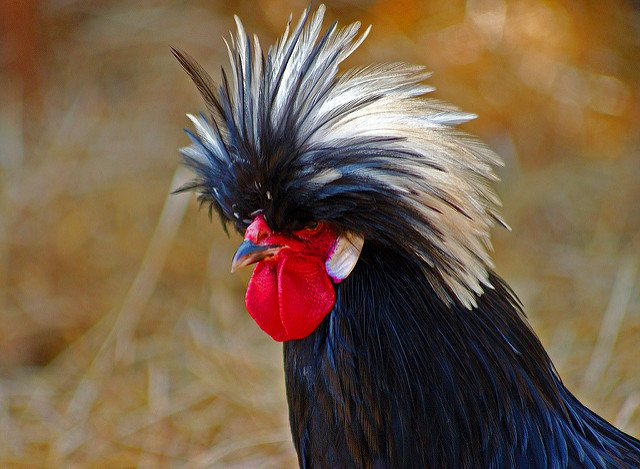

(640, 469)


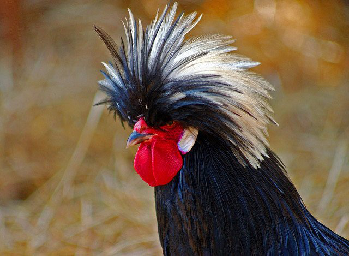

(349, 256)
[0.6409439444541931, 0.3590560555458069]
['Normal', 'Abnormal']


In [31]:
# TODO: Implement the code to predict the class from an image file
def predict(image_path, model, topk=2):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    image = Image.open(image_path)
    image = process_image(image).unsqueeze(dim=0)
    image = image.type(torch.FloatTensor)
    logps = model(image)
    ps = torch.exp(logps)
    top_ps, top_class = ps.topk(topk, dim=1)
    
    idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
    
    top_ps = [top_p.item() for top_p in top_ps.squeeze()]
    top_class = [idx_to_class[top_class.item()] for top_class in top_class.squeeze()]
    return top_ps, top_class
        
model = torch.jit.load('model.pt')

image_name  = os.listdir(f"{data_dir}/test/Abnormal")[0]
image_path = f"{data_dir}/test/Abnormal/{image_name}"
probs, classes = predict(image_path, model)
print(probs)
print(classes)

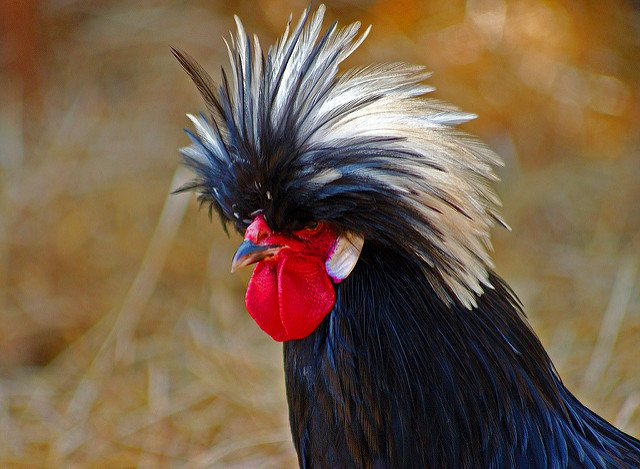

(640, 469)


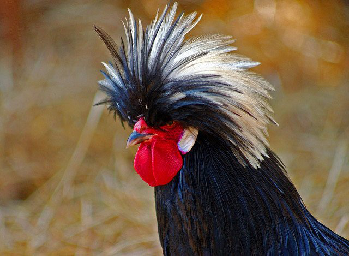

(349, 256)


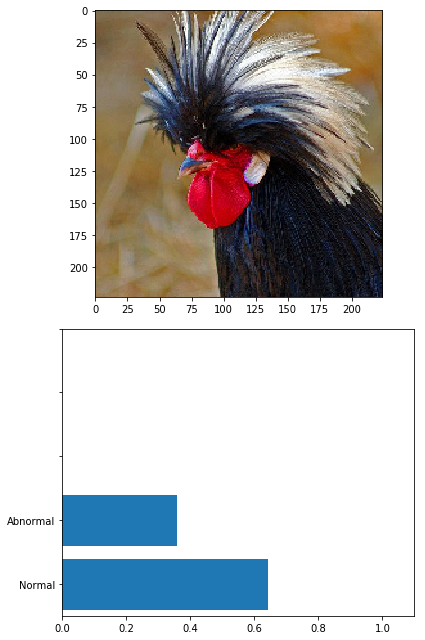

In [33]:
# TODO: Display an image along with the top 5 classes
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), nrows=2)

image = Image.open(image_path)
image = process_image(image)

imshow(image, ax1)

ax2.barh(np.arange(2), probs)
ax2.set_aspect(0.2)
ax2.set_yticks(np.arange(5))

ax2.set_yticklabels(classes);
ax2.set_xlim(0, 1.1)

plt.tight_layout()